In [1]:
!pip install tensorflow==2.0.0rc0 &> log
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.9MB 21.6MB/s 
     |████████████████████████████████| 450kB 61.4MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import revnet
import ops
import blocks

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("init_kernel", 3)
  config.add_hparam("init_stride", 1)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 1)
  config.add_hparam("n_res", [1])
  config.add_hparam("filters", [32])
  config.add_hparam("strides", [1])
  config.add_hparam("batch_size", 64)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("init_max_pool", False)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)
  config.add_hparam("last_dense", True)

  config.add_hparam("epochs", 30)
  config.add_hparam("weight_decay", 2e-4)
  
  return config

# Revnet on Imagenette with averagePooling and Dense at the end

In [3]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xzf imagenette2.tgz

--2020-03-12 09:38:59--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  35.9MB/s    in 42s     

2020-03-12 09:39:42 (35.0 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()


Epoch: 1
Training loss over epoch: 2.272152900695801
Training acc over epoch: 0.14246489107608795

Val loss over epoch: 2.2275469303131104
Val acc over epoch: 0.17273885011672974

Epoch: 2
Training loss over epoch: 2.122722625732422
Training acc over epoch: 0.2115323692560196

Val loss over epoch: 2.1239538192749023
Val acc over epoch: 0.22726114094257355

Epoch: 3
Training loss over epoch: 2.0692412853240967
Training acc over epoch: 0.24796704947948456

Val loss over epoch: 2.0753021240234375
Val acc over epoch: 0.2557961642742157

Epoch: 4
Training loss over epoch: 2.0210366249084473
Training acc over epoch: 0.27246806025505066

Val loss over epoch: 2.0250163078308105
Val acc over epoch: 0.2929936349391937

Epoch: 5
Training loss over epoch: 1.9832789897918701
Training acc over epoch: 0.2991868257522583

Val loss over epoch: 1.9849029779434204
Val acc over epoch: 0.3133758008480072

Epoch: 6
Training loss over epoch: 1.955523133277893
Training acc over epoch: 0.3210476338863373

Val 

In [0]:
model.save_weights("drive/My Drive/Диплом/small_revnet.hdf5")

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()


Epoch: 1
Training loss over epoch: 1.6649614572525024
Training acc over epoch: 0.40278804302215576

Val loss over epoch: 1.789826512336731
Val acc over epoch: 0.3770700693130493

Epoch: 2
Training loss over epoch: 1.6414738893508911
Training acc over epoch: 0.39972540736198425

Val loss over epoch: 1.765004277229309
Val acc over epoch: 0.36840763688087463

Epoch: 3
Training loss over epoch: 1.6302164793014526
Training acc over epoch: 0.3981412947177887

Val loss over epoch: 2.148939371109009
Val acc over epoch: 0.30038216710090637

Epoch: 4
Training loss over epoch: 1.634036898612976
Training acc over epoch: 0.4012039303779602

Val loss over epoch: 1.7034881114959717
Val acc over epoch: 0.43847134709358215

Epoch: 5
Training loss over epoch: 1.606808066368103
Training acc over epoch: 0.4338367283344269

Val loss over epoch: 2.5921871662139893
Val acc over epoch: 0.30904459953308105

Epoch: 6
Training loss over epoch: 1.6014846563339233
Training acc over epoch: 0.40606188774108887

Val 

In [0]:
model.save_weights("drive/My Drive/Диплом/small_revnet.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/small_revnet.hdf5")

In [0]:
max_val_acc = None

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/small_revnet.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 1.4163328409194946
Training acc over epoch: 0.4849509000778198

Val loss over epoch: 2.3283772468566895
Val acc over epoch: 0.31821656227111816

Epoch: 2
Training loss over epoch: 1.412247896194458
Training acc over epoch: 0.4760798513889313

Val loss over epoch: 1.9105056524276733
Val acc over epoch: 0.34471338987350464

Epoch: 3
Training loss over epoch: 1.4107301235198975
Training acc over epoch: 0.457492858171463

Val loss over epoch: 1.9421988725662231
Val acc over epoch: 0.39592355489730835

Epoch: 4
Training loss over epoch: 1.4021551609039307
Training acc over epoch: 0.4791424572467804

Val loss over epoch: 1.5928959846496582
Val acc over epoch: 0.4611465036869049

Epoch: 5
Training loss over epoch: 1.402735710144043
Training acc over epoch: 0.48811912536621094

Val loss over epoch: 1.4294030666351318
Val acc over epoch: 0.5271337628364563

Epoch: 6
Training loss over epoch: 1.3935909271240234
Training acc over epoch: 0.47365087270736694

Val 

In [0]:
model.load_weights("drive/My Drive/Диплом/small_revnet.hdf5")

# Deep network

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("init_kernel", 3)
  config.add_hparam("init_stride", 1)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 3)
  config.add_hparam("n_res", [3, 3, 3])
  config.add_hparam("filters", [32, 64, 128])
  config.add_hparam("strides", [1, 2, 2])
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("init_max_pool", False)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 30)
  config.add_hparam("weight_decay", 2e-4)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
max_val_acc = None

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/deep_revnet.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 2.023622989654541
Training acc over epoch: 0.16400887072086334

Val loss over epoch: 2.2449164390563965
Val acc over epoch: 0.18598726391792297

Epoch: 2
Training loss over epoch: 1.8045897483825684
Training acc over epoch: 0.27289047837257385

Val loss over epoch: 1.8305209875106812
Val acc over epoch: 0.38140127062797546

Epoch: 3
Training loss over epoch: 1.692293643951416
Training acc over epoch: 0.4018375873565674

Val loss over epoch: 1.6987874507904053
Val acc over epoch: 0.43541401624679565

Epoch: 4
Training loss over epoch: 1.6087888479232788
Training acc over epoch: 0.3866300582885742

Val loss over epoch: 2.653132200241089
Val acc over epoch: 0.3006369471549988

Epoch: 5
Training loss over epoch: 1.5417991876602173
Training acc over epoch: 0.43109092116355896

Val loss over epoch: 1.811933159828186
Val acc over epoch: 0.385987251996994

Epoch: 6
Training loss over epoch: 1.4861570596694946
Training acc over epoch: 0.45326855778694153

Val 

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)
        
    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/deep_revnet.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 0.7734256386756897
Training acc over epoch: 0.6536065340042114

Val loss over epoch: 1.4451807737350464
Val acc over epoch: 0.5294267535209656

Epoch: 2
Training loss over epoch: 0.7654151320457458
Training acc over epoch: 0.6350195407867432

Val loss over epoch: 1.1196942329406738
Val acc over epoch: 0.6537579894065857

Epoch: 3
Training loss over epoch: 0.7478824853897095
Training acc over epoch: 0.6506494879722595

Val loss over epoch: 1.1636593341827393
Val acc over epoch: 0.6229299306869507

Epoch: 4
Training loss over epoch: 0.7196611166000366
Training acc over epoch: 0.640194296836853

Val loss over epoch: 1.4435114860534668
Val acc over epoch: 0.5921019315719604

Epoch: 5
Training loss over epoch: 0.7176632881164551
Training acc over epoch: 0.6369204521179199

Val loss over epoch: 1.2234101295471191
Val acc over epoch: 0.6323567032814026

Epoch: 6
Training loss over epoch: 0.7031348943710327
Training acc over epoch: 0.6447354555130005

Val los

In [0]:
model.load_weights("drive/My Drive/Диплом/deep_revnet.hdf5")

In [0]:
max_val_acc = 0.6537579894065857
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/deep_revnet.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 0.69097501039505
Training acc over epoch: 0.7900517582893372

Val loss over epoch: 0.7946702837944031
Val acc over epoch: 0.7551592588424683

Epoch: 2
Training loss over epoch: 0.6696837544441223
Training acc over epoch: 0.8095892071723938

Val loss over epoch: 0.7745457887649536
Val acc over epoch: 0.7628025412559509

Epoch: 3
Training loss over epoch: 0.6575670838356018
Training acc over epoch: 0.815820038318634

Val loss over epoch: 0.7714776396751404
Val acc over epoch: 0.7650955319404602

Epoch: 4
Training loss over epoch: 0.6541677713394165
Training acc over epoch: 0.8152920007705688

Val loss over epoch: 0.7725800275802612
Val acc over epoch: 0.7640764117240906

Epoch: 5
Training loss over epoch: 0.6458198428153992
Training acc over epoch: 0.81613689661026

Val loss over epoch: 0.776652455329895
Val acc over epoch: 0.759235680103302

Epoch: 6
Training loss over epoch: 0.6488146781921387
Training acc over epoch: 0.8202555775642395

Val loss over

In [0]:
model.load_weights("drive/My Drive/Диплом/deep_revnet.hdf5")

In [0]:
max_val_acc = 0.7755414247512817
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)
        
    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/deep_revnet.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 0.5889984369277954
Training acc over epoch: 0.84517902135849

Val loss over epoch: 0.7333523035049438
Val acc over epoch: 0.7742674946784973

Epoch: 2
Training loss over epoch: 0.5929688811302185
Training acc over epoch: 0.8435949087142944

Val loss over epoch: 0.7331615686416626
Val acc over epoch: 0.7747770547866821

Epoch: 3
Training loss over epoch: 0.5876966714859009
Training acc over epoch: 0.8458126783370972

Val loss over epoch: 0.7342945337295532
Val acc over epoch: 0.7745223045349121

Epoch: 4
Training loss over epoch: 0.5849401354789734
Training acc over epoch: 0.8460238575935364

Val loss over epoch: 0.7326850891113281
Val acc over epoch: 0.7740127444267273

Epoch: 5
Training loss over epoch: 0.5845290422439575
Training acc over epoch: 0.8464462757110596

Val loss over epoch: 0.7357541918754578
Val acc over epoch: 0.7757961750030518



KeyboardInterrupt: ignored

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))

        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/deep_revnet.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 0.5913726687431335
Training acc over epoch: 0.836519181728363

Val loss over epoch: 0.745390772819519
Val acc over epoch: 0.7729936242103577

Epoch: 2
Training loss over epoch: 0.5853171944618225
Training acc over epoch: 0.8428556323051453

Val loss over epoch: 0.7310742139816284
Val acc over epoch: 0.7752866148948669

Epoch: 3
Training loss over epoch: 0.5841914415359497
Training acc over epoch: 0.838948130607605

Val loss over epoch: 0.7321981191635132
Val acc over epoch: 0.7735031843185425

Epoch: 4
Training loss over epoch: 0.5754898190498352
Training acc over epoch: 0.8394761681556702

Val loss over epoch: 0.7479255199432373
Val acc over epoch: 0.7712101936340332

Epoch: 5
Training loss over epoch: 0.5769689679145813
Training acc over epoch: 0.8463407158851624

Val loss over epoch: 0.7364203333854675
Val acc over epoch: 0.7732484340667725

Epoch: 6
Training loss over epoch: 0.5650516152381897
Training acc over epoch: 0.8476079702377319

Val loss 

In [0]:
model.load_weights("drive/My Drive/Диплом/deep_revnet.hdf5")

# Gradient-based attack 

In [0]:
from gradient_attack import choose_images, attack

In [0]:
attack_gen = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse",
                                          shuffle=True, batch_size=1, target_size=(224, 224))

Found 3925 images belonging to 10 classes.


Attacked image: 
Logits:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Predicted:  7
Real:  7


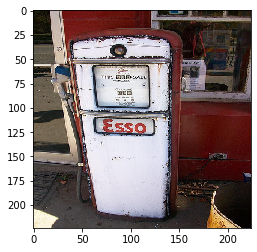

Changing image: 
Logits:  [2.4493537e-03 1.3353448e-02 8.6081570e-01 9.7104505e-02 3.6427681e-04
 1.4929953e-02 4.6531172e-04 1.8979837e-03 7.8642461e-03 7.5508893e-04]
Predicted:  2
Real:  2


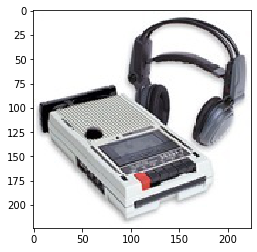

In [0]:
attacked_img, changed_img = choose_images(model, attack_gen=attack_gen, is_custom_model=True, from_logits=True, threshold=0.8)

Loss :  0.14551108
Predict of changing image:  1
Logits of changing image:  [5.6182384e-04 5.6343460e-01 7.7224667e-03 4.1663319e-01 1.3367074e-04
 9.4536915e-03 6.4714416e-04 2.9290919e-04 6.2090741e-04 4.9949036e-04]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


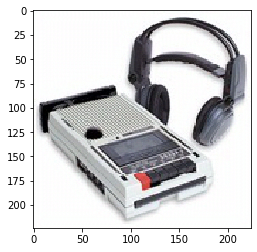

Source image to be changed:


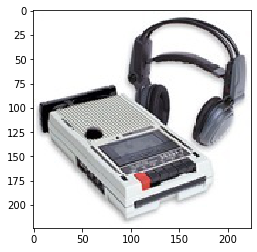

Loss :  0.1399082
Predict of changing image:  2
Logits of changing image:  [3.1662738e-04 2.3768904e-02 6.8506640e-01 1.1160612e-01 1.7160209e-02
 1.2296584e-01 4.9828347e-03 2.8303256e-02 4.7880262e-03 1.0417795e-03]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


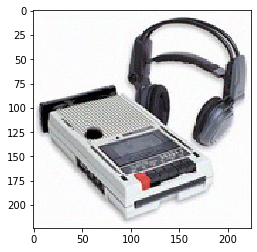

Source image to be changed:


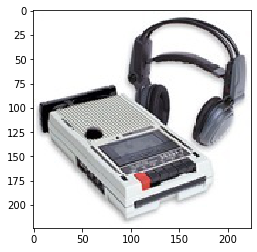

Loss :  0.0044511827
Predict of changing image:  7
Logits of changing image:  [5.1844905e-05 6.0828570e-03 8.6669393e-02 1.8899839e-02 1.2947946e-02
 1.0038830e-02 6.4706631e-02 7.9806703e-01 1.8766813e-03 6.5885624e-04]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


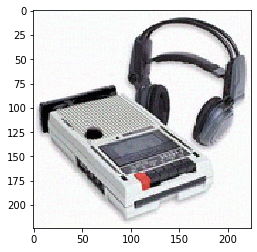

Source image to be changed:


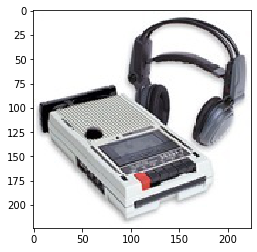

Loss :  1.3438282e-05
Predict of changing image:  7
Logits of changing image:  [1.8470548e-07 4.4283071e-05 2.0784612e-03 1.2524555e-04 2.3516016e-04
 9.2454706e-05 4.4082529e-03 9.9299228e-01 1.5489048e-05 8.2117713e-06]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


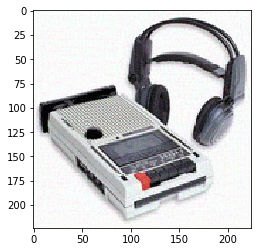

Source image to be changed:


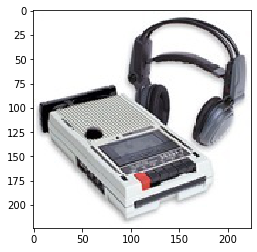

In [0]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign)

Loss :  0.13717589
Predict of changing image:  3
Logits of changing image:  [3.6298465e-03 1.9207661e-01 1.7121321e-01 5.8827102e-01 5.7432649e-04
 3.3534516e-02 1.3675381e-03 1.9055681e-03 5.5352431e-03 1.8921559e-03]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


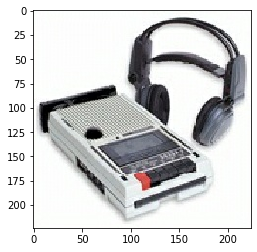

Source image to be changed:


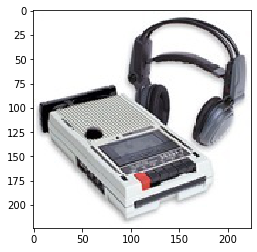

Loss :  0.1362411
Predict of changing image:  2
Logits of changing image:  [0.00180277 0.04585418 0.59446913 0.24951486 0.00380406 0.08183749
 0.00238529 0.00987261 0.00851236 0.00194724]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


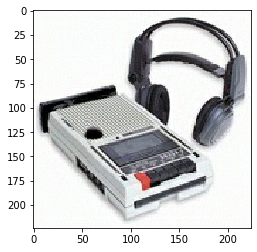

Source image to be changed:


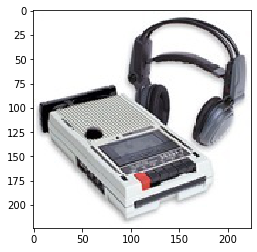

Loss :  0.10307761
Predict of changing image:  2
Logits of changing image:  [0.00149192 0.06715128 0.3859687  0.33257014 0.00874824 0.05677006
 0.02203818 0.10586321 0.01507555 0.00432283]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


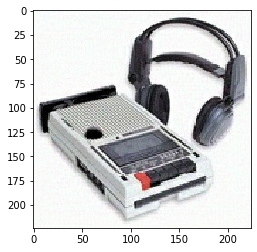

Source image to be changed:


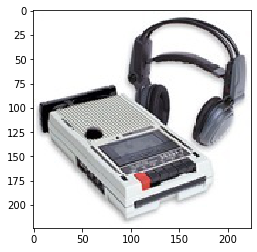

Loss :  0.044351146
Predict of changing image:  7
Logits of changing image:  [0.00081337 0.02441284 0.19146062 0.23959817 0.01992404 0.04597209
 0.06692667 0.3947604  0.01085465 0.00527719]
Logits of attacked image:  [5.7689012e-06 1.9676576e-04 6.5578618e-03 1.0905453e-03 2.1966461e-03
 1.1230402e-03 5.8879112e-03 9.8268545e-01 7.7052238e-05 1.7896295e-04]
Changed image:


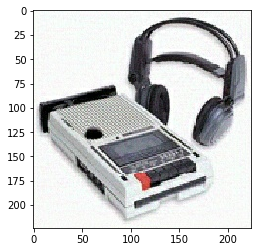

Source image to be changed:


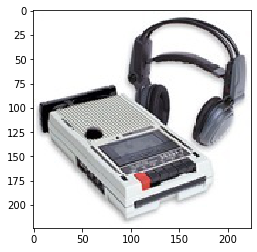

In [0]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign, with_jpeg=True)

Attacked image: 
Logits:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Predicted:  8
Real:  8


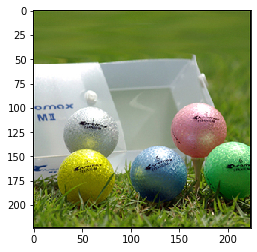

Changing image: 
Logits:  [3.6007521e-04 2.4056521e-03 4.4412203e-02 2.7195306e-03 7.5259381e-03
 1.4530870e-03 4.2795464e-02 8.9645422e-01 6.7522313e-04 1.1986030e-03]
Predicted:  7
Real:  7


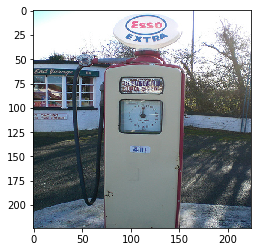

In [0]:
attacked_img, changed_img = choose_images(model, attack_gen=attack_gen, is_custom_model=True, from_logits=True, threshold=0.8)

Loss :  0.13223492
Predict of changing image:  6
Logits of changing image:  [0.02917077 0.01114805 0.36223322 0.03919519 0.00732177 0.00800562
 0.48484725 0.04049449 0.00844129 0.00914237]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


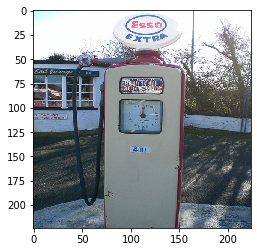

Source image to be changed:


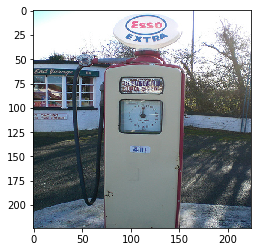

Loss :  6.511541e-06
Predict of changing image:  8
Logits of changing image:  [2.6731056e-03 2.1834383e-03 1.1843008e-03 9.5401582e-04 2.4970257e-04
 9.7690798e-05 4.9598111e-05 3.8864088e-04 9.8962897e-01 2.5905725e-03]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


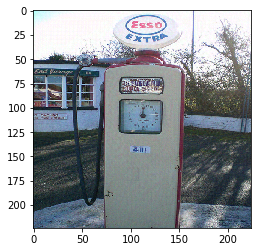

Source image to be changed:


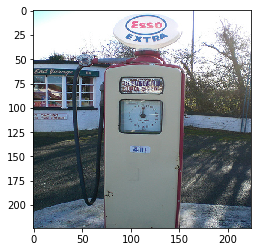

Loss :  0.00018497003
Predict of changing image:  8
Logits of changing image:  [1.9934805e-02 7.8281453e-03 4.1854414e-03 4.9601868e-03 1.9850959e-03
 6.5094122e-04 3.9682630e-04 1.9451196e-03 9.4492847e-01 1.3185057e-02]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


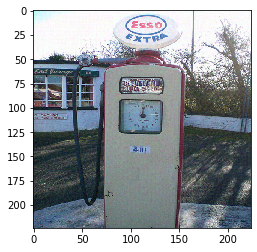

Source image to be changed:


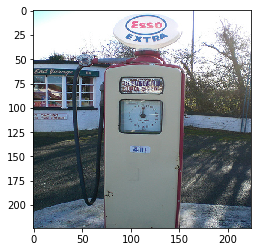

Loss :  2.0307236e-06
Predict of changing image:  8
Logits of changing image:  [4.9784384e-03 2.0782312e-03 1.0147198e-03 1.0138251e-03 3.8380845e-04
 1.1143984e-04 6.8563582e-05 3.8892619e-04 9.8669821e-01 3.2637627e-03]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


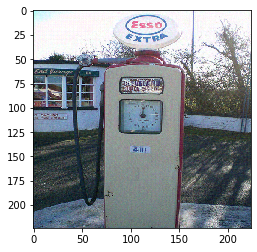

Source image to be changed:


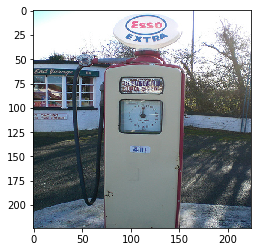

In [0]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign)

Loss :  0.124951504
Predict of changing image:  7
Logits of changing image:  [0.01004333 0.01062353 0.21139123 0.02530402 0.02256421 0.00784531
 0.30755836 0.39018434 0.00614195 0.00834367]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


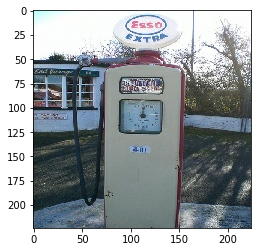

Source image to be changed:


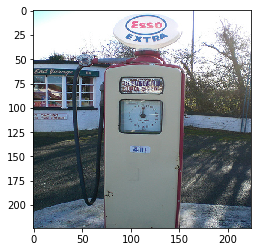

Loss :  0.012038255
Predict of changing image:  8
Logits of changing image:  [0.05014326 0.04104469 0.05561248 0.04353458 0.02204397 0.0074417
 0.00805132 0.06449722 0.6595334  0.04809742]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


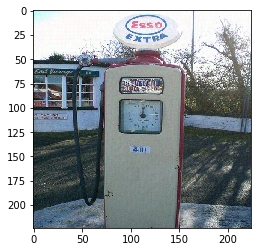

Source image to be changed:


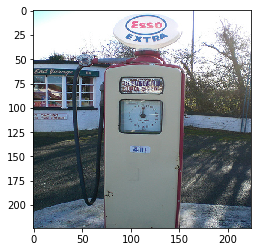

Loss :  0.018128617
Predict of changing image:  8
Logits of changing image:  [0.08265425 0.04763237 0.05028731 0.0545386  0.03112149 0.00946281
 0.01082908 0.06481148 0.58513963 0.06352302]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


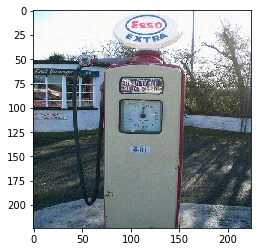

Source image to be changed:


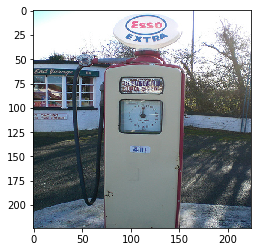

Loss :  0.005495158
Predict of changing image:  8
Logits of changing image:  [0.05495236 0.02933978 0.02773443 0.02898112 0.01558299 0.00453823
 0.00468452 0.02963213 0.7651316  0.03942284]
Logits of attacked image:  [7.9104993e-03 1.0250979e-03 1.4228106e-04 6.5206806e-04 2.5795927e-04
 1.4968171e-04 6.2090745e-05 1.2740790e-04 9.8436487e-01 5.3080041e-03]
Changed image:


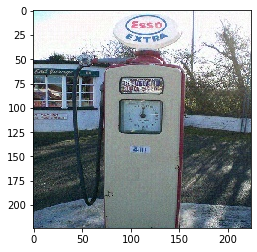

Source image to be changed:


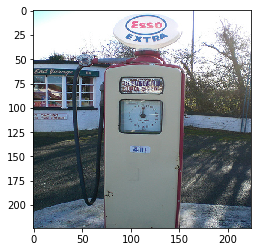

In [0]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign, with_jpeg=True)

Attacked image: 
Logits:  [2.8800673e-04 3.5463701e-04 4.5367196e-04 3.5332580e-04 9.5403129e-01
 2.3981573e-03 1.1720893e-03 1.8462014e-03 2.2494961e-03 3.6853142e-02]
Predicted:  4
Real:  4


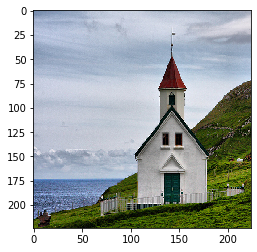

Changing image: 
Logits:  [0.00282614 0.00158132 0.00680632 0.01865337 0.03996991 0.00475537
 0.0038249  0.00357366 0.07862569 0.8393834 ]
Predicted:  9
Real:  9


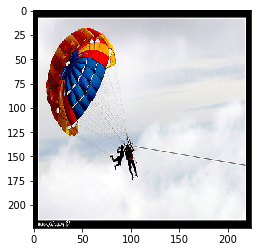

In [0]:
attacked_img, changed_img = choose_images(model, attack_gen=attack_gen, is_custom_model=True, from_logits=True, threshold=0.6)

Loss :  0.096807614
Predict of changing image:  9
Logits of changing image:  [0.00502321 0.00486452 0.05552977 0.02134824 0.1317237  0.01484794
 0.00471742 0.01433578 0.22038728 0.52722216]
Logits of attacked image:  [2.8800673e-04 3.5463701e-04 4.5367196e-04 3.5332580e-04 9.5403129e-01
 2.3981573e-03 1.1720893e-03 1.8462014e-03 2.2494961e-03 3.6853142e-02]
Changed image:


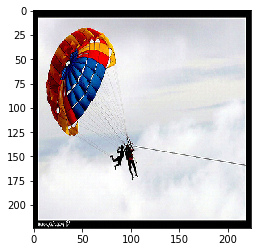

Source image to be changed:


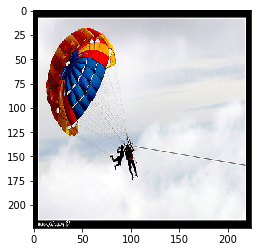

Loss :  6.3156585e-05
Predict of changing image:  4
Logits of changing image:  [1.07202985e-04 8.47507035e-05 8.01806105e-04 2.47549760e-04
 9.73430216e-01 1.53565884e-03 4.37591982e-04 7.87835394e-04
 1.59425556e-03 2.09730696e-02]
Logits of attacked image:  [2.8800673e-04 3.5463701e-04 4.5367196e-04 3.5332580e-04 9.5403129e-01
 2.3981573e-03 1.1720893e-03 1.8462014e-03 2.2494961e-03 3.6853142e-02]
Changed image:


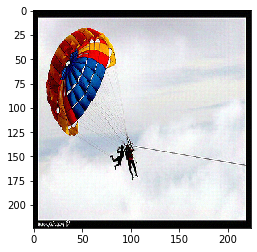

Source image to be changed:


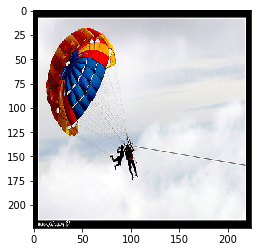

Loss :  5.870369e-07
Predict of changing image:  4
Logits of changing image:  [1.8980980e-04 1.4466528e-04 9.9952216e-04 4.0776105e-04 9.5585835e-01
 2.1129202e-03 6.2919786e-04 1.1171795e-03 2.7141769e-03 3.5826460e-02]
Logits of attacked image:  [2.8800673e-04 3.5463701e-04 4.5367196e-04 3.5332580e-04 9.5403129e-01
 2.3981573e-03 1.1720893e-03 1.8462014e-03 2.2494961e-03 3.6853142e-02]
Changed image:


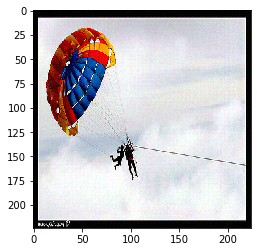

Source image to be changed:


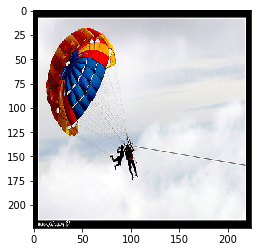

Loss :  0.0002948832
Predict of changing image:  4
Logits of changing image:  [5.1047414e-04 5.1671191e-04 4.7167530e-03 1.3339756e-03 9.0827763e-01
 5.8972016e-03 1.2706766e-03 3.4437443e-03 9.4344737e-03 6.4598314e-02]
Logits of attacked image:  [2.8800673e-04 3.5463701e-04 4.5367196e-04 3.5332580e-04 9.5403129e-01
 2.3981573e-03 1.1720893e-03 1.8462014e-03 2.2494961e-03 3.6853142e-02]
Changed image:


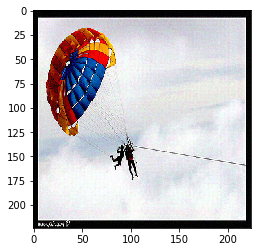

Source image to be changed:


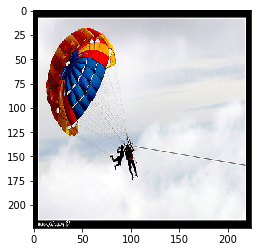

In [0]:
attack(model, attacked_img, changed_img, is_custom_model=True, from_logits=True, eps=0.005, fn=tf.sign,)